In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load FID data
data_fid = pd.read_csv('/content/GC Data 11_06_2024 - Copy of PeakTableFID.csv', skiprows=3)
selected_columns_fid = data_fid.columns[19:33]
data_selected_fid = data_fid[selected_columns_fid].replace('n.a.', np.nan).astype(float)

# Load TCD data
data_tcd = pd.read_csv('/content/GC Data 11_06_2024 - Copy of PeakTableTCD.csv', skiprows=2)
data_selected_tcd = data_tcd.iloc[1:, 22].replace('n.a.', np.nan).astype(float)

data_selected_fid.head()
data_selected_tcd.head()

1        NaN
2    25.8699
3    26.0013
4    26.0288
5    25.9881
Name: Unnamed: 22, dtype: float64

In [ ]:
# Known inlet flow rates (nml)
n_in_CO2 = 12.5
n_in_H2 = 37.5

In [ ]:
# Calculating molar flow rates for the outgoing streams
total_volumetric_flow_in_ml = n_in_CO2 + n_in_H2


In [ ]:
# Extracting outgoing molar fractions for all relevant hydrocarbons and other gases from FID data
components = ['CH4_FID.1', 'Ethen.1', 'Ethan.1', 'CO2.1', 'Propan.1', 'iso-Butan.1',
              'n-Butan.1', 'x-Buten.1', 'O2/Ar.1', 'N2.1', 'n-Pentane.1', 'CH4_WLD.1',
              'n-Hexane.1', 'CO.1']

In [ ]:
# Convert total volumetric flow rate to molar flow rate (mol/s)
total_volumetric_flow_in_m3_s = total_volumetric_flow_in_ml * 1e-6  # convert ml to m^3
R = 8.314  # J/(mol*K)
T = 273.15  # K
P = 101325  # Pa


In [ ]:
total_molar_flow_rate_in = total_volumetric_flow_in_m3_s * P / (60 * R * T)

# Calculate the molar flow rates of each component
component_molar_flow_rates = data_selected_fid * total_molar_flow_rate_in

# Ensuring the length of data_selected_tcd matches component_molar_flow_rates
data_selected_tcd = data_selected_tcd[:len(component_molar_flow_rates)]

# Extracting CO2 data from TCD data and convert to molar flow rates
x_CO2_out = data_selected_tcd.iloc[:len(component_molar_flow_rates)].fillna(0) / 100  # convert volume % to fraction
n_CO2_out = x_CO2_out * total_molar_flow_rate_in



In [ ]:
# Function to calculate selectivity
def calculate_selectivity(n_out_i, n_out_CO2, delta_n_CO2):
    return n_out_i / (np.sum(n_out_i) * delta_n_CO2)

In [ ]:
# Initial estimate for delta_n_CO2
delta_n_CO2 = np.zeros(len(n_CO2_out))

In [ ]:
# Iterative calculation for delta_n_CO2
tolerance = 1e-6
for i in range(1000):  # Limiting the number of iterations
    # Change made here to ensure lengths match
    new_delta_n_CO2 = (n_in_CO2 - n_CO2_out) / (1 + component_molar_flow_rates.sum(axis=1))
    if np.all(np.abs(new_delta_n_CO2 - delta_n_CO2) < tolerance):
        break
    delta_n_CO2 = new_delta_n_CO2

# Calculate the selectivities for each component
selectivities = {}
for component in selected_columns_fid:
    selectivities[component] = calculate_selectivity(component_molar_flow_rates[component].fillna(0), n_CO2_out, delta_n_CO2)

# Calculating outgoing molar flow rates
n_out_H2O = 2 * delta_n_CO2
n_out_H2 = n_in_H2 - delta_n_CO2 * (3 * selectivities['CH4_FID.1'] + 2 * selectivities['Ethen.1'])



ValueError: operands could not be broadcast together with shapes (306,) (305,) 

In [ ]:
results = {
    'n_out_H2O': n_out_H20,
    'n_out_H2': n_out_H2,
}
results.update(selectivities)


NameError: name 'n_out_H2O' is not defined

In [ ]:
# Calculate the conversion of CO2
conversion_CO2 = (n_in_CO2 - delta_n_CO2) / n_in_CO2

# Calculate the flow rates of the components
flow_rates = component_molar_flow_rates.multiply(total_molar_flow_rate_in - delta_n_CO2, axis=0)

print("Results:", results)
print("Conversion of CO2:", conversion_CO2)
print("Flow rates of components:", flow_rates)

Results: {'n_out_H2O': 0     -14945.861880
1      -6330.966520
2      -6184.890949
3      -5934.343652
4      -5887.013408
           ...     
300   -15279.154600
301   -15279.154600
302   -15279.154600
303   -15279.154600
304   -15279.154600
Length: 305, dtype: float64, 'n_out_H2': 0            NaN
1      37.467933
2      37.491408
3      37.466990
4      37.490678
         ...    
300          NaN
301          NaN
302          NaN
303          NaN
304          NaN
Length: 305, dtype: float64, 'CH4_FID.1': 0     -5.897712e-09
1     -8.695353e-07
2     -9.261811e-07
3     -1.033624e-06
4     -1.055699e-06
           ...     
300             NaN
301             NaN
302             NaN
303             NaN
304             NaN
Length: 305, dtype: float64, 'Ethen.1': 0           NaN
1     -0.000004
2     -0.000000
3     -0.000004
4     -0.000000
         ...   
300         NaN
301         NaN
302         NaN
303         NaN
304         NaN
Length: 305, dtype: float64, 'Ethan.1': 0          

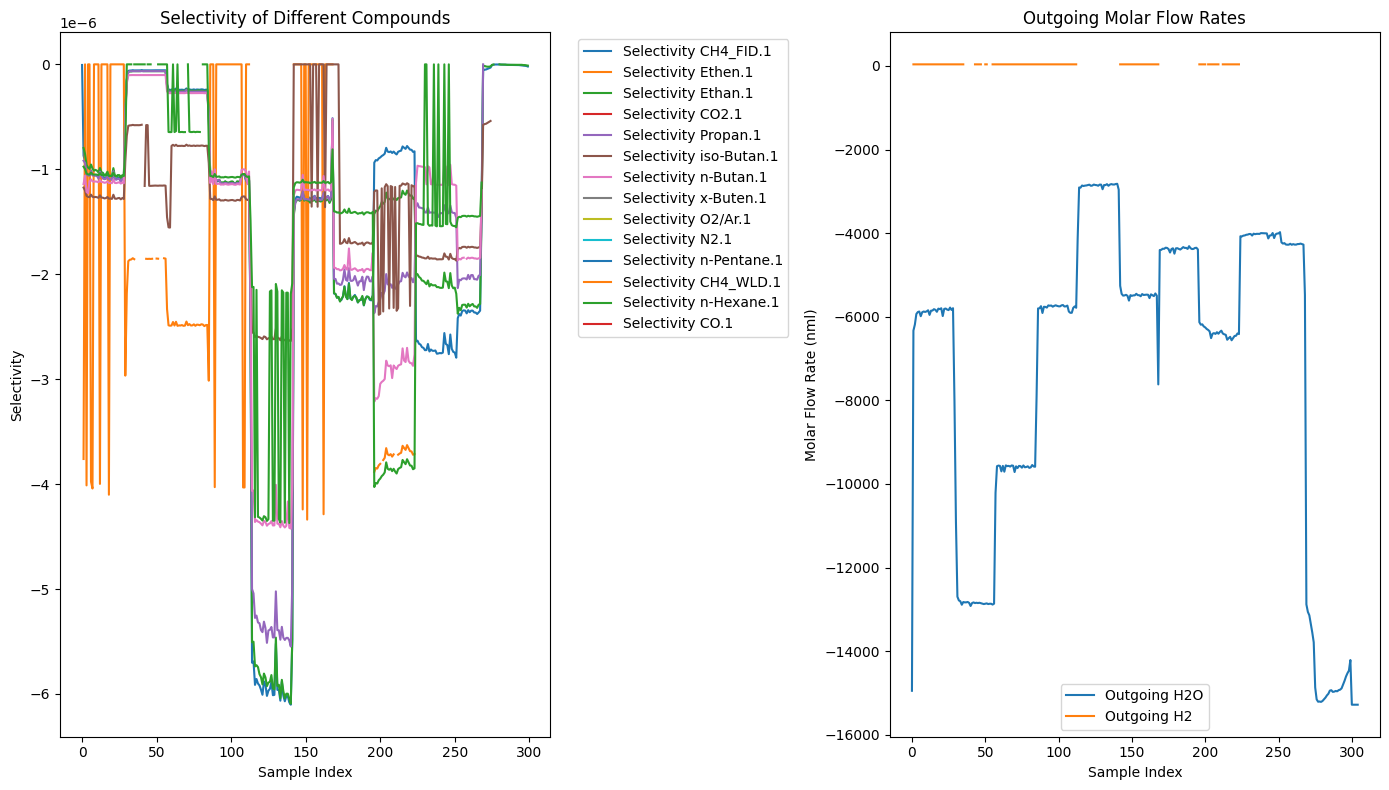

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 8))

# Selectivity plot
plt.subplot(1, 2, 1)
for component in components:
    plt.plot(selectivities[component], label=f'Selectivity {component}')
plt.xlabel('Sample Index')
plt.ylabel('Selectivity')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.legend(loc='upper left', bbox_to_anchor=(2,1))
plt.title('Selectivity of Different Compounds')

# Molar flow rates plot
plt.subplot(1, 2, 2)
plt.plot(n_out_H2O, label='Outgoing H2O')
plt.plot(n_out_H2, label='Outgoing H2')
plt.xlabel('Sample Index')
plt.ylabel('Molar Flow Rate (nml)')
plt.legend()
plt.title('Outgoing Molar Flow Rates')

plt.tight_layout()
plt.show()